In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from helpers.loader import load_dataset_path, load_input_mask_img, create_training_test_dataset
from helpers.labels import InputLayoutElements, GroundTruthLayoutElements
from helpers.labels import get_SpaceElementClasses, get_SpaceFunctionClasses
from helpers.augmentors import inp_out_augmentation
from helpers.visulaizator import visulaize_inp_pred_gt
from helpers.models import get_unet_model, get_vgg16_unet_model
from helpers.evlauator import mIoU, f1_measure, total_error
from tensorflow.keras.metrics import MeanIoU

# ==============================================================================
Author: Amir Ziaee, Georg Suter, Mihael Barada
Copyright: Design Computing Group TU Wien, 2022
Credits: Design Computing Group TU Wien
License: GNU GENERAL PUBLIC LICENSE Version 3
Version: 1.0.1
Maintainer: Amir Ziaee
Email: amir.ziaee@tuwien.ac.at
Status: Prototype
Description: SFS-A68: a dataset for the segmentation of space functions in apartment buildings
Url: https://github.com/A2Amir/SFS-A68
# ==============================================================================


### 1. Data Structure

In [2]:
### Input Layout Elements and their colors
InputLayoutElements.show(idhidden=False, data_property="color")

None[root]
├── None[Space]
│   ├── (102,102,122)[InternalSpace]
│   └── (161,162,155)[ExternalSpace]
└── None[SpaceElement]
    ├── None[SpaceContainedElement]
    │   ├── None[CirculationElement]
    │   │   ├── (230, 184, 175)[FlightOfStairs]
    │   │   └── (102, 1, 30)[Landing]
    │   ├── None[FurnishingElement]
    │   │   ├── (253, 223, 162)[KitchenElement]
    │   │   └── (248, 193, 79)[SanitaryElemen]
    │   └── None[EquipmentElement]
    │       └── None[HomeAppliance]
    │           └── (159, 140, 81)[TextileCareAppliance]
    └── None[SpaceEnclosingElement]
        ├── (109, 189, 110)[Opening]
        ├── (255, 107, 0)[Partition]
        ├── (200, 255, 0)[Window]
        └── None[Door]
            ├── (0, 255, 0)[RegularDoor]
            ├── (72, 112, 39)[UnitDoor]
            └── (187, 244, 154)[ElevatorDoor]



In [3]:
### Ground Truth Layout Elements and their colors
GroundTruthLayoutElements.show(idhidden=False, data_property="color")

None[Space]
├── None[ResidentialSpace]
│   ├── None[CommunalSpace]
│   │   ├── (107,74,101)[DiningRoom]
│   │   ├── (166, 206, 227)[FamilyRoom]
│   │   └── (242, 0, 192)[LivingRoom]
│   └── None[PrivateSpace]
│       ├── (0, 255, 248)[Bedroom]
│       │   ├── (0,175,175)[MasterBedroom]
│       │   └── (4,72,148)[BoxRoom]
│       └── (194, 123, 160)[HomeOffice]
├── None[ServiceSpace]
│   ├── (253, 237, 0)[Shaft]
│   ├── (255, 182, 0)[StorageRoom]
│   │   └── (191, 144, 0)[WalkInCloset]
│   └── None[SanitarySpace]
│       ├── (255, 0, 0)[Bathroom]
│       ├── (69, 129, 142)[Toilet]
│       ├── (131, 126, 197)[Kitchen]
│       └── (0, 0, 255)[LaundryRoom]
├── None[CirculationSpace]
│   ├── None[VerticalCirculationSpace]
│   │   ├── (9, 244, 156)[Elevator]
│   │   └── (168, 134, 113)[Stairway]
│   └── None[HorizontalCirculationSpace]
│       ├── (151, 143, 141)[Entrance]
│       └── (125, 62, 32)[Hallway]
│           ├── (225, 138, 96)[MainHallway]
│           └── (155, 94, 65)[InternalHal

### 2. Load Data

In [4]:
dataset_path = "./data"
dataset_paths = load_dataset_path(dataset_path)

Number of input images: 68
Number of space function images: 68


In [5]:
X_train_path, y_train_path, X_test_path, y_test_path = create_training_test_dataset(dataset_paths,
                                                                                    test_size=0.20,
                                                                                    shuffle=True,
                                                                                    random_state=13)

Number of training data: 54
Number of test data: 14


### 3. Create TF Dataset

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 3
EPOCHS = 100
SEG_CLASSES = get_SpaceFunctionClasses()
OUTPUT_CHANNELS = len(SEG_CLASSES)
# to resize 
HEIGHT = 320
WIDTH = 320

# path to save prediction
pred_path = './test_results/UnetTrainingFromScratch'

In [7]:
for k,item in SEG_CLASSES.items():
    print(item.id, item.name, item.color)

1 DiningRoom (107,74,101)
2 FamilyRoom (166, 206, 227)
3 LivingRoom (242, 0, 192)
4 Bedroom (0, 255, 248)
5 MasterBedroom (0,175,175)
6 BoxRoom (4,72,148)
7 HomeOffice (194, 123, 160)
8 Shaft (253, 237, 0)
9 StorageRoom (255, 182, 0)
10 WalkInCloset (191, 144, 0)
11 Bathroom (255, 0, 0)
12 Toilet (69, 129, 142)
13 Kitchen (131, 126, 197)
14 LaundryRoom (0, 0, 255)
15 Elevator (9, 244, 156)
16 Stairway (168, 134, 113)
17 Entrance (151, 143, 141)
18 Hallway (125, 62, 32)
19 MainHallway (225, 138, 96)
20 InternalHallway (155, 94, 65)
21 AccessBalcony (255, 255, 22)
22 Loggia (120, 56, 145)


In [8]:
train_dataset =  tf.data.Dataset.from_tensor_slices((X_train_path, y_train_path))
train_dataset = train_dataset.map(lambda x,y: tf.py_function(load_input_mask_img, [x,y , HEIGHT, WIDTH], [tf.float32, tf.float32]))
#train_dataset = train_dataset.map(lambda x,y: load_input_mask_img(x,y , HEIGHT, WIDTH))

# for input and ground truth augmentation
train_dataset = train_dataset.map(inp_out_augmentation)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [9]:
test_dataset =  tf.data.Dataset.from_tensor_slices((X_test_path, y_test_path))
test_dataset = test_dataset.map(lambda x,y: tf.py_function(load_input_mask_img, [x,y , HEIGHT, WIDTH], [tf.float32, tf.float32]))
test_dataset = test_dataset.batch(14)

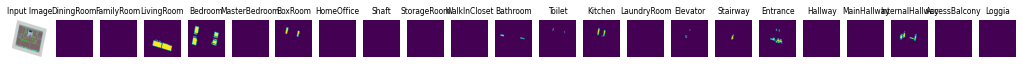

In [10]:
for inp_img, space_func__img in test_dataset.take(2):
    plt.figure(figsize=(18,18))
    display_list = [inp_img[13,:,:,:]*.5+.5]
    display_title = ['Input Image']
    
    for i,title in enumerate(SEG_CLASSES.keys()):
        display_list.append(space_func__img[13,:,:,i])
        display_title.append(title)

    for i in range(len(SEG_CLASSES.keys())+1):
        plt.subplot(1, len(SEG_CLASSES.keys())+1, i+1)
        plt.title(display_title[i], fontsize=7.5)
        plt.imshow(display_list[i] )
        plt.axis('off')
    plt.show()

### 4. Build U-Net

In [11]:
# To train from scratch
unet_model = get_unet_model (input_size=(HEIGHT, WIDTH, 3), n_labels=OUTPUT_CHANNELS)

adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=.9, beta_2=.999, epsilon=1e-08)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),

unet_model.compile(optimizer = adam, loss = loss)

In [12]:
unet_model = tf.keras.models.load_model('./unet_model')

### 5. Train  U-Net

In [ ]:
## Unfreeze both the decoder and encoder and train them simultaneously 
# with a learning rate of 0.001 and an epoch number of 100.

for l in unet_model.layers:
    l.trainable = True
    
adam.learning_rate.assign(0.001)
unet_model.fit(train_dataset,epochs= 100)

In [13]:
# Unfreeze all the encoder layers and train them with a learning rate of 0.0001
# and an epoch number of 100, while the decoder layers are frozen.

for l in unet_model.layers:
    if 'up'  in l.name:
        l.trainable = False
    else:
        l.trainable = True
        
adam.learning_rate.assign(0.0001)
unet_model.fit(train_dataset,epochs= 100)

Epoch 1/100
18/18 [==============================] - 10s 398ms/step - loss: 0.6932
Epoch 2/100
18/18 [==============================] - 13s 566ms/step - loss: 0.6932
Epoch 3/100
18/18 [==============================] - 11s 479ms/step - loss: 0.6932
Epoch 4/100
18/18 [==============================] - 12s 499ms/step - loss: 0.6932
Epoch 5/100
18/18 [==============================] - 11s 478ms/step - loss: 0.6932
Epoch 6/100
18/18 [==============================] - 11s 462ms/step - loss: 0.6932
Epoch 7/100
18/18 [==============================] - 12s 494ms/step - loss: 0.6932
Epoch 8/100
18/18 [==============================] - 10s 397ms/step - loss: 0.6932
Epoch 9/100
18/18 [==============================] - 10s 402ms/step - loss: 0.6932
Epoch 10/100
18/18 [==============================] - 10s 405ms/step - loss: 0.6932
Epoch 11/100
18/18 [==============================] - 13s 565ms/step - loss: 0.6932
Epoch 12/100
18/18 [==============================] - 12s 531ms/step - loss: 0.6932
E

In [14]:
# Train the decoder with a learning rate of 0.0001
# and an epoch number of 100, while the pre-trained U2-Net encoder layers are frozen.

for l in unet_model.layers:
    if 'down'  in l.name:
        l.trainable = False
    else:
        l.trainable = True
        
adam.learning_rate.assign(0.0001)       
unet_model.fit(train_dataset,epochs= 100)

Epoch 1/100
18/18 [==============================] - 6s 190ms/step - loss: 0.6932
Epoch 2/100
18/18 [==============================] - 9s 337ms/step - loss: 0.6932
Epoch 3/100
18/18 [==============================] - 8s 272ms/step - loss: 0.6932
Epoch 4/100
18/18 [==============================] - 10s 408ms/step - loss: 0.6932
Epoch 5/100
18/18 [==============================] - 6s 190ms/step - loss: 0.6932
Epoch 6/100
18/18 [==============================] - 8s 264ms/step - loss: 0.6932
Epoch 7/100
18/18 [==============================] - 6s 189ms/step - loss: 0.6932
Epoch 8/100
18/18 [==============================] - 6s 190ms/step - loss: 0.6932
Epoch 9/100
18/18 [==============================] - 6s 190ms/step - loss: 0.6932
Epoch 10/100
18/18 [==============================] - 6s 191ms/step - loss: 0.6932
Epoch 11/100
18/18 [==============================] - 9s 354ms/step - loss: 0.6932
Epoch 12/100
18/18 [==============================] - 11s 495ms/step - loss: 0.6932
Epoch 13/10

Epoch 99/100
18/18 [==============================] - 13s 591ms/step - loss: 0.6930
Epoch 100/100
18/18 [==============================] - 13s 570ms/step - loss: 0.6930


In [18]:
unet_model.save('./unet_model')

INFO:tensorflow:Assets written to: ./unet_model\assets


### 5. Evalutae VGG16 U-Net

In [13]:
X_test, y_test = next(iter(test_dataset))
y_pred = unet_model.predict(X_test)

In [14]:
MIoU, iou_per_class, ious_per_class = mIoU(y_pred, y_test,  threshold=0.5, target_class_ids=[1])

In [15]:
for k,item in SEG_CLASSES.items():
    print('{}, {}, IoUs: {}, IoU: {}'.format(item.id, item.name, ious_per_class[item.id-1], iou_per_class[item.id-1]))

1, DiningRoom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
2, FamilyRoom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
3, LivingRoom, IoUs: [0.28 0.07 0.48 0.51 0.32 0.05 0.57 0.32 0.63 0.52 0.   0.58 0.   0.64], IoU: 0.36
4, Bedroom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
5, MasterBedroom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
6, BoxRoom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
7, HomeOffice, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
8, Shaft, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
9, StorageRoom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
10, WalkInCloset, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
11, Bathroom, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
12, Toilet, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
13, Kitchen, IoUs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], IoU: 0.0
14, La

In [18]:
# LivingRoom IoU, exclude zeros, sum all, dividev by Test layout count from the paper
round((0.28 +0.07 +0.48+ 0.51+ 0.32+ 0.05+ 0.57+ 0.32+ 0.63+ 0.52+ 0.58 +  0.63) / 14, 2)

0.35

In [18]:
mean_F1_measure, F1_measures = f1_measure(y_test, y_pred)

In [19]:
for k,item in SEG_CLASSES.items():
    print('{}, {}, F_measure: {}'.format(item.id, item.name, F1_measures[item.id-1]))

1, DiningRoom, F_measure: 0.0
2, FamilyRoom, F_measure: 0.0
3, LivingRoom, F_measure: 0.58
4, Bedroom, F_measure: 0.0
5, MasterBedroom, F_measure: 0.0
6, BoxRoom, F_measure: 0.0
7, HomeOffice, F_measure: 0.0
8, Shaft, F_measure: 0.0
9, StorageRoom, F_measure: 0.0
10, WalkInCloset, F_measure: 0.0
11, Bathroom, F_measure: 0.0
12, Toilet, F_measure: 0.0
13, Kitchen, F_measure: 0.0
14, LaundryRoom, F_measure: 0.0
15, Elevator, F_measure: 0.0
16, Stairway, F_measure: 0.0
17, Entrance, F_measure: 0.0
18, Hallway, F_measure: 0.0
19, MainHallway, F_measure: 0.0
20, InternalHallway, F_measure: 0.0
21, AccessBalcony, F_measure: 0.0
22, Loggia, F_measure: 0.0


In [20]:
Mtotal_error, total_error_per_class, total_errors_per_class = total_error(y_pred, y_test)

In [21]:
for k,item in SEG_CLASSES.items():
    print('{}, {},  Total error: {}'.format(item.id, item.name, total_error_per_class[item.id-1]))

1, DiningRoom,  Total error: 0.0
2, FamilyRoom,  Total error: 0.0
3, LivingRoom,  Total error: 0.057
4, Bedroom,  Total error: 0.044
5, MasterBedroom,  Total error: 0.007
6, BoxRoom,  Total error: 0.001
7, HomeOffice,  Total error: 0.001
8, Shaft,  Total error: 0.001
9, StorageRoom,  Total error: 0.001
10, WalkInCloset,  Total error: 0.0
11, Bathroom,  Total error: 0.009
12, Toilet,  Total error: 0.001
13, Kitchen,  Total error: 0.007
14, LaundryRoom,  Total error: 0.001
15, Elevator,  Total error: 0.002
16, Stairway,  Total error: 0.009
17, Entrance,  Total error: 0.005
18, Hallway,  Total error: 0.0
19, MainHallway,  Total error: 0.002
20, InternalHallway,  Total error: 0.005
21, AccessBalcony,  Total error: 0.006
22, Loggia,  Total error: 0.002


In [21]:
X_test_path

['./data\\0066\\input\\0066_input.png',
 './data\\0065\\input\\0065_input.png',
 './data\\0030\\input\\0030_input.png',
 './data\\0063\\input\\0063_input.png',
 './data\\0009\\input\\0009_input.png',
 './data\\0044\\input\\0044_input.png',
 './data\\0052\\input\\0052_input.png',
 './data\\0039\\input\\0039_input.png',
 './data\\0015\\input\\0015_input.png',
 './data\\0040\\input\\0040_input.png',
 './data\\0001\\input\\0001_input.png',
 './data\\0037\\input\\0037_input.png',
 './data\\0004\\input\\0004_input.png',
 './data\\0005\\input\\0005_input.png']

### 6. Visualize

(14, 320, 320, 3) (14, 320, 320, 22)


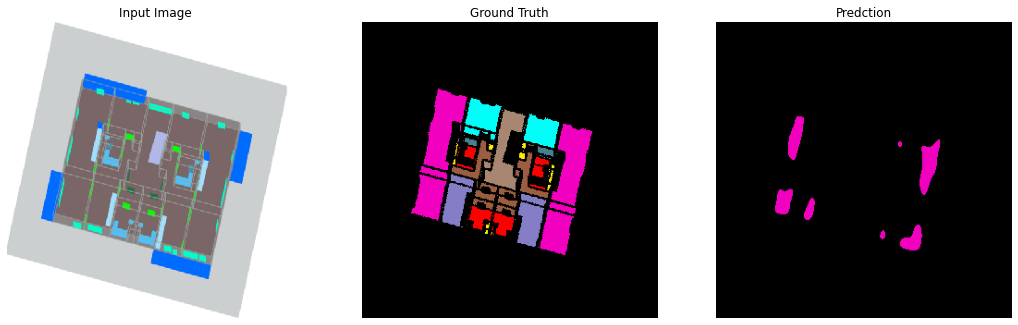

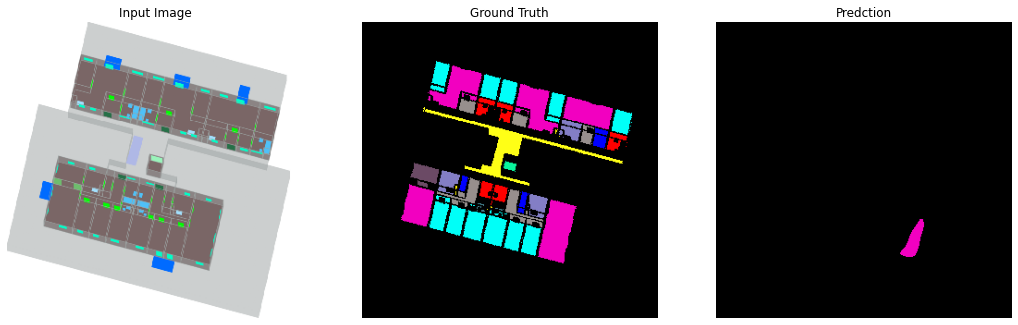

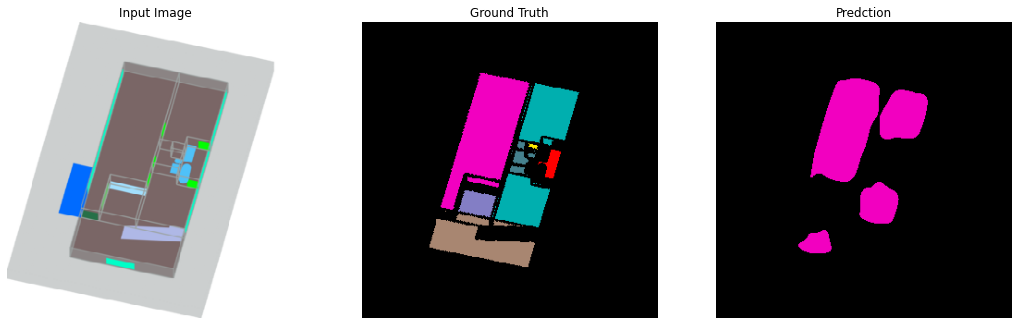

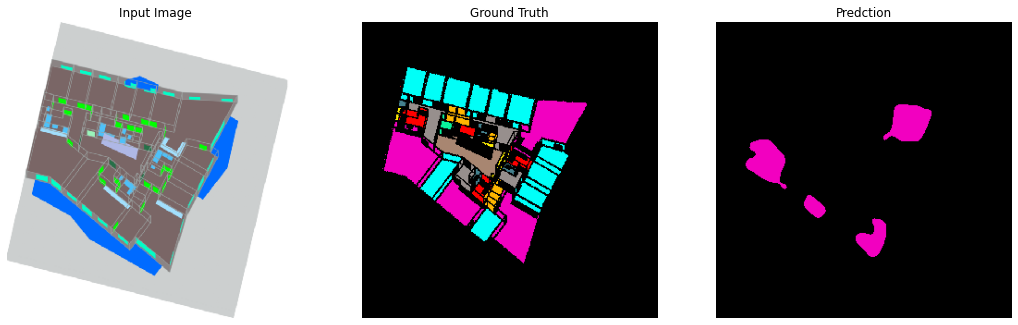

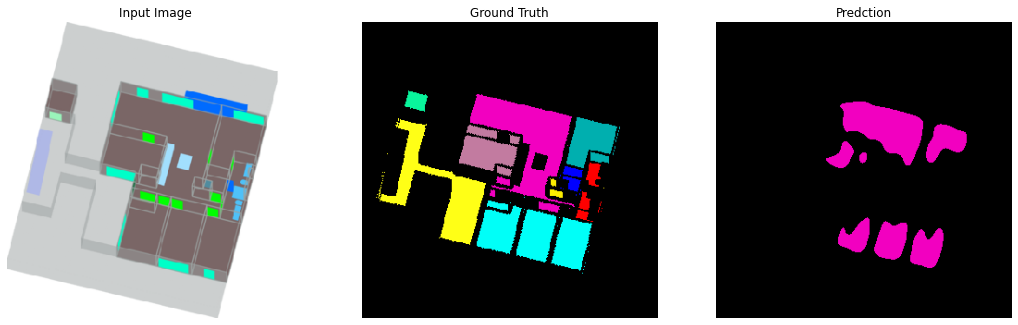

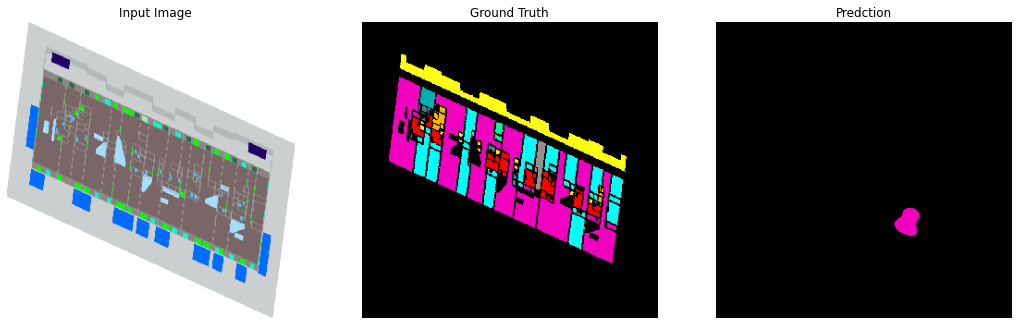

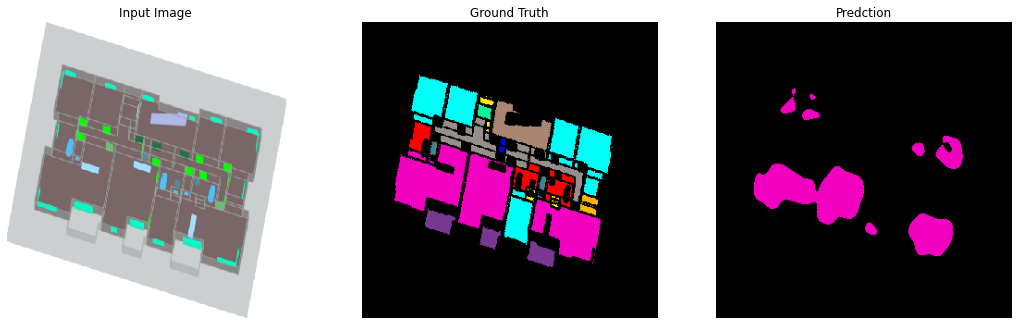

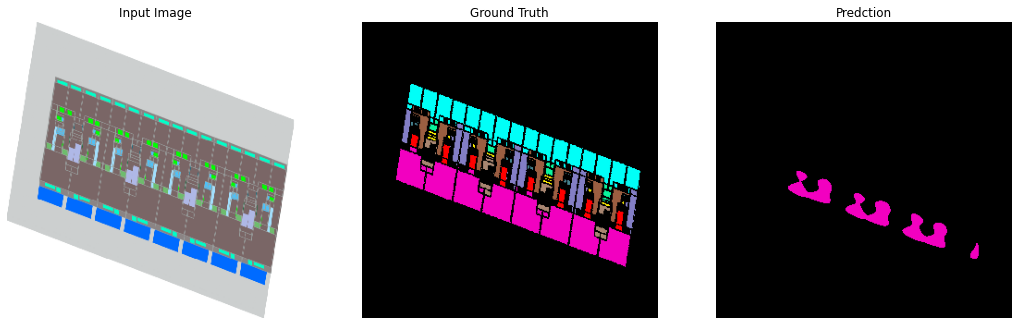

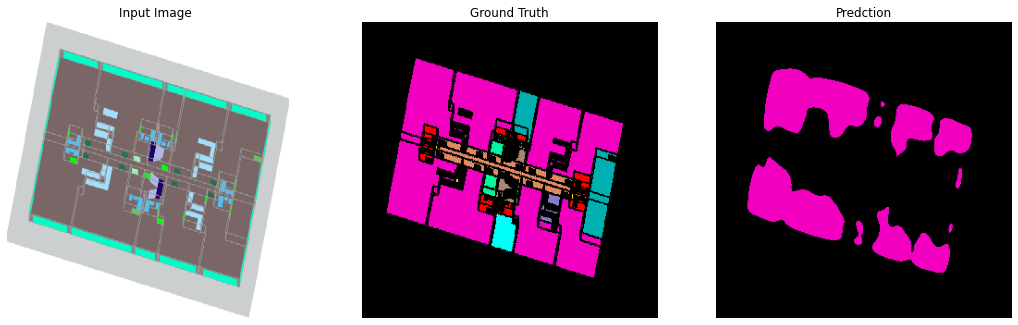

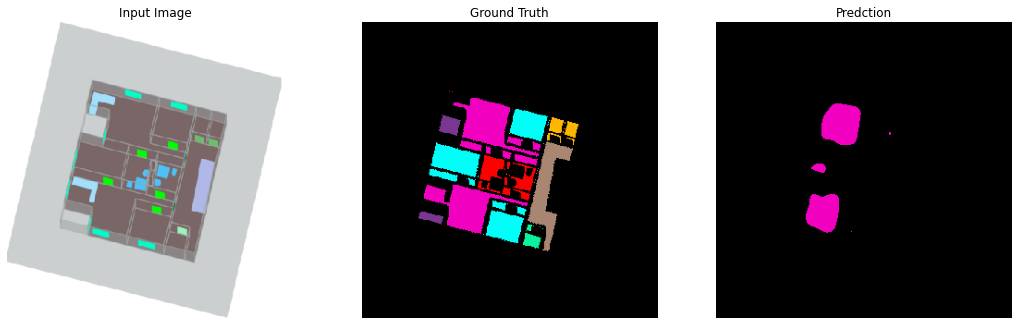

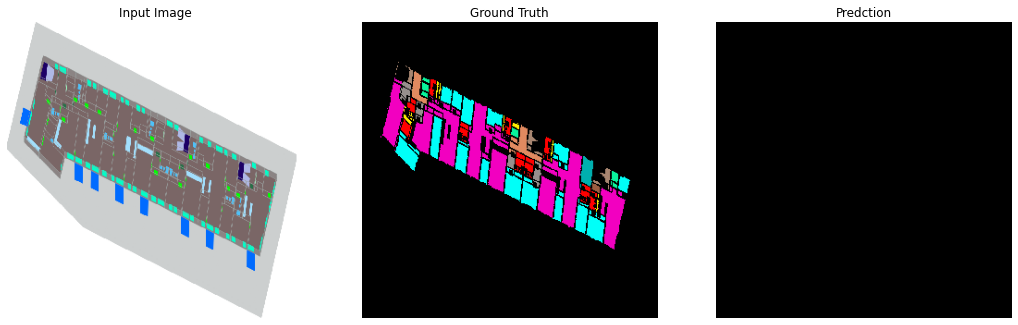

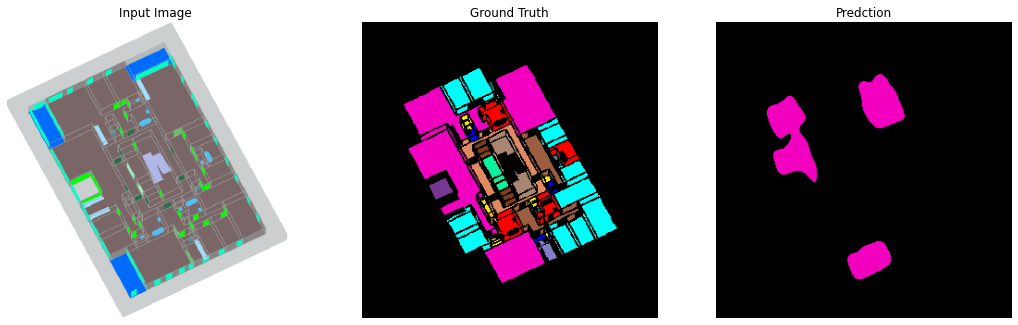

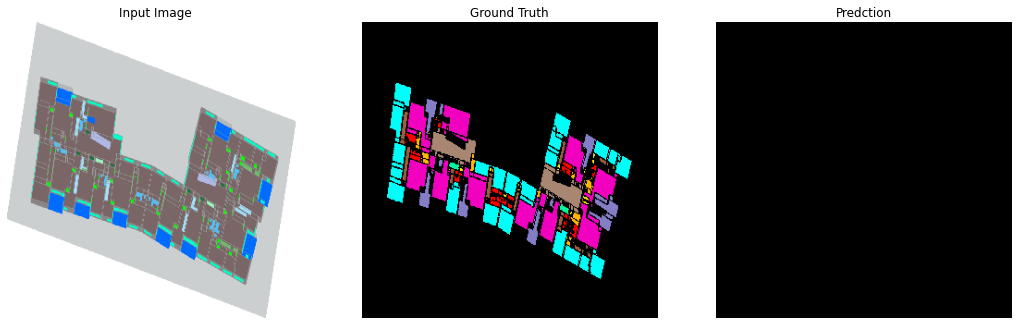

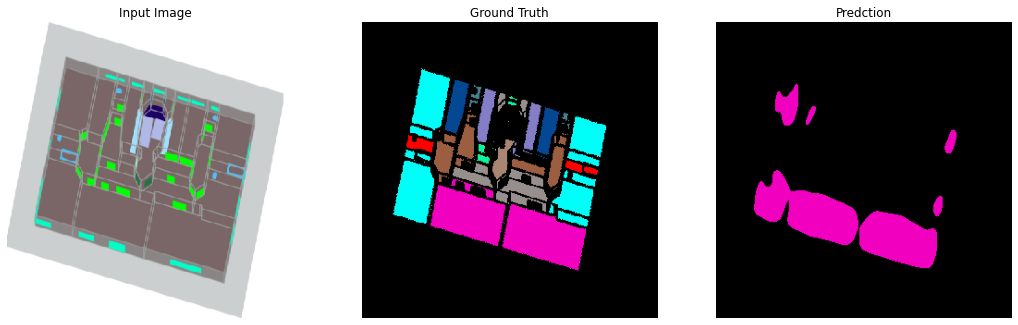

In [22]:
print(X_test.shape, y_pred.shape)

for i, path in enumerate(X_test_path):
    name = path.split('\\')[1]
    visulaize_inp_pred_gt(X_test[i], y_pred[i], y_test[i], HEIGHT, WIDTH, SEG_CLASSES, pred_path, name, save=True)